In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

In [32]:
# parameters cell
meshpath = '/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/'
abg = [50, 15, -90]
variable = 'temp'
input_paths = ['/Users/nkolduno/PYTHON/DATA/output_7_8/',
               "/Users/nkolduno/PYTHON/DATA/output_7_10/",
               ]
input_names = ['control', 'opt1']
years = range(1978, 1986)
reference_path = '/Users/nkolduno/PYTHON/DATA/CLIM_on_mesh/core2_meanz/'
reference_name = 'clim'
reference_years = 1948
figsize=(10, 5)
levels = [-1, 1, 41]
maxdepth = 2000
units = r'$^\circ$C'
columns = 2
dpi = 200
ofile = None
region = "Eurasian basin"
cached_path = None

In [33]:
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])


In [34]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2


In [62]:
def get_data_cache(cached_path,
                   exp_name,
                   exp_path,
                   variable,
                   years,
                   mesh,
                   depth=None, 
                   how='mean',
                   compute=True,
                   silent=True):
    
    if cached_path is None:
        cached_path = exp_path
    
    if depth is None:
        depth_cache = '3d'
    else:
        depth_cache = depth
        
    if how is None:
        how_cache = "timeseries"
    else:
        how_cache = "how"
        
    if cached_path is False:
        data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=compute,
                               silent=silent)
        return data_out
    
    else:
        if not isinstance(years, (list, np.ndarray, range)):
            years_str = [years]
        else:
            years_str = years
        print(years_str)
        cached_file = f"{cached_path}/{exp_name}_{variable}_{years_str[0]}_{years_str[-1]}_{depth_cache}_{how_cache}.nc"
        print(cached_file)
        if os.path.exists(cached_file):
            print('use cached')
            data_out = xr.open_dataset(cached_file)
            data_out = data_out[variable]
        else:
            print('compute')
            data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=False,
                               silent=silent)
            data_out.to_netcdf(cached_file)
    if compute:
        data_out = data_out.compute()
        data_out = data_out.data
                
    return data_out

In [63]:
hofm = OrderedDict()
mask = pf.get_mask(mesh, region)
data_reference = get_data_cache(cached_path, reference_name, reference_path, variable, reference_years, mesh, how=None, silent=True, compute=False)
hofm_reference = pf.hovm_data(data_reference, mesh, mask = mask)
for exp_path, exp_name  in zip(input_paths, input_names):
    data = get_data_cache(cached_path, exp_name, exp_path, variable, years, mesh, how=None, compute=False, silent=True)
    title = exp_name+" - "+reference_name
    hofm[title] = {}
    data_difference= pf.hovm_data(data, mesh, mask = mask) - hofm_reference.data
    hofm[title]['data'] = data_difference
    if (data_difference.max() == data_difference.min() == 0):
        hofm[title]['nodiff'] = True
    else:
        hofm[title]['nodiff'] = False
    del data
    print(exp_name)

[1948]
/Users/nkolduno/PYTHON/DATA/CLIM_on_mesh/core2_meanz//clim_temp_1948_1948_3d_timeseries.nc
compute
range(1978, 1986)
/Users/nkolduno/PYTHON/DATA/output_7_8//control_temp_1978_1985_3d_timeseries.nc
compute


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control
range(1978, 1986)
/Users/nkolduno/PYTHON/DATA/output_7_10//opt1_temp_1978_1985_3d_timeseries.nc
compute
opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [64]:
def data_to_plot(hofm):
    plot_data = []
    plot_names = []
    for key, value in hofm.items():
        if value['nodiff'] is False:
            plot_data.append(value['data'])
            plot_names.append(key)
                
    return plot_data, plot_names

In [65]:
plot_data, plot_names = data_to_plot(hofm)
if not plot_data:
    print('There is no difference between fields')
    identical = True
else:
    identical = False

if len(plot_data) == 1:
    plot_data = plot_data[0]
    plot_names = plot_names[0]

<Figure size 720x360 with 0 Axes>

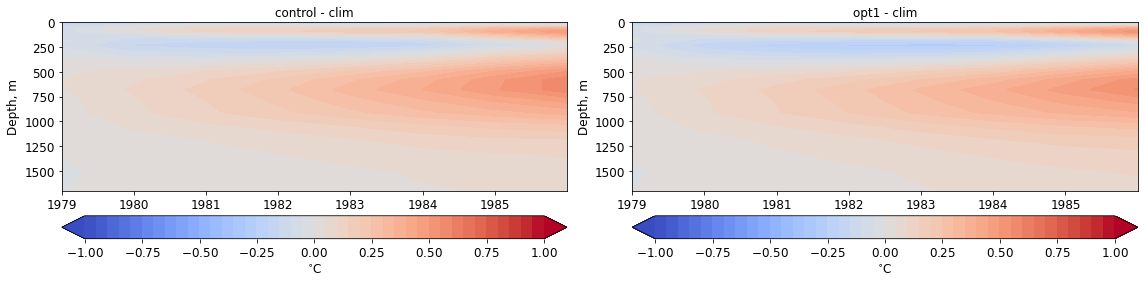

In [66]:
plt.figure(figsize=(10, 5))
pf.plot_xyz(mesh, plot_data,
             levels = levels, maxdepth=maxdepth, cmap = cm.coolwarm, title=plot_names, ncols=columns)
if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')